In [48]:
from numpy import ones, zeros, kron, diag, array, linspace, pi
from numpy import concatenate as cat
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import matplotlib as mpl
pi = np.pi

In [49]:
import scipy.signal, scipy.interpolate
import scipy.sparse as sp
import scipy.sparse.linalg as slinalg

In [50]:
%matplotlib widget

In [51]:
cmap = mpl.colormaps['viridis']

In [52]:
def f(x, y):
    return np.sqrt((x ** 2 + y ** 2))

def one_cone():
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:5j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = f(x, y)
    return x / 2, y / 2, -(z - 2/3)

def Rx(phi):
    c, s = np.cos(phi), np.sin(phi)
    return np.array([[1, 0, 0],
                     [0, c,-s],
                     [0, s, c]])

def Ry(phi):
    c, s = np.cos(phi), np.sin(phi)
    return np.array([[ c, 0, s],
                     [ 0, 1, 0],
                     [-s, 0, c]])

def Rz(phi):
    c, s = np.cos(phi), np.sin(phi)
    return np.array([[c, -s, 0],
                     [s,  c, 0],
                     [0,  0,  1]])

def rotate(x, y, z, phi, theta):
    R = Rz(theta) @ Ry(phi)
    coords = np.stack((x,y,z)).reshape(3, -1)
    return (R @ coords).reshape(3, *x.shape)

def translate(x, y, z, tx, ty, tz):
    return x + tx, y + ty, z + tz

def plot_cone(ax, phi, theta, tx, ty, tz):
    # cones are length 4.                                                           
    x, y, z = translate(*rotate(*one_cone(), phi, theta), tx, ty, tz)
    cmap = mpl.colormaps['plasma']
    ax.plot_surface(x, y, z, color=cmap(int((np.cos(phi) + 1) * 127)), shade=False)

def cone_plot(ax, Xs, Ys, phis, thetas, spatial_scale=1):
    Xs = Xs.reshape(-1)
    Ys = Ys.reshape(-1)
    phis = phis.reshape(-1)
    thetas = thetas.reshape(-1)
    for i in range(Xs.shape[0]):
        plot_cone(ax, float(phis[i]), float(thetas[i]), Xs[i] * spatial_scale, Ys[i\
] * spatial_scale, 0)
    return None

def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,     
    cubes as cubes, etc..  This is one possible solution to Matplotlib's            
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.                 
                                                                                    
    Input                                                                           
      ax: a matplotlib axis, e.g., as output from plt.gca().                        
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity                
    # norm, hence I call half the max range the plot radius.                        
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [53]:
# only work for square lattices
def SSF_parallel(field):
    return np.abs(np.fft.fft2(field[2], norm="ortho"))**2

# only work for square lattices
def SSF_perpendicular(field):
    n1, n2 = field.shape[1], field.shape[2]
    return np.roll(np.roll(np.linalg.norm(np.fft.fft2(field[0:2], norm="ortho"), axis=0)**2, n1//2, axis=0), n2//2, axis=1)

In [54]:
# from stack exchange
class scatter():
    def __init__(self,x,y,ax,size=1,**kwargs):
        self.n = len(x)
        self.ax = ax
        self.ax.figure.canvas.draw()
        self.size_data=size
        self.size = size
        self.sc = ax.scatter(x,y,s=self.size,**kwargs)
        self._resize()
        self.cid = ax.figure.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self,event=None):
        ppd=72./self.ax.figure.dpi
        trans = self.ax.transData.transform
        s =  ((trans((1,self.size_data))-trans((0,0)))*ppd)[1]
        if s != self.size:
            self.sc.set_sizes(s**2*np.ones(self.n))
            self.size = s
            self._redraw_later()
    
    def _redraw_later(self):
        self.timer = self.ax.figure.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.ax.figure.canvas.draw_idle())
        self.timer.start()

# custom triangular lattice plotter
def show_wavefunction(ax, coordinates, values, vmin=None, vmax=None, colorbar=True):
    if vmin is None: vmin = np.min(values)
    if vmax is None: vmax = np.max(values)
    colors = mpl.colormaps['viridis']((values - vmin) / (vmax - vmin))
    cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    scatter(coordinates[0].reshape(-1), coordinates[1].reshape(-1), ax, size=1.1, c=colors.reshape(-1, 4), marker="h")
    
    if colorbar:
        plt.colorbar(cm.ScalarMappable(norm=cNorm, cmap=cmap), ax=ax, fraction=0.046, pad=0.04)
    ax.tick_params(axis='both', left=False, labelleft=False, which='both', bottom=False, top=False, labelbottom=False) 
    
    return None

In [55]:
# makes coordinates and adjacency matrix for periodic triangular lattice
def periodic_2dtriangular_lattice(n1, n2, dtype='complex128'):
    grid = np.zeros((n1 * n2, n1 * n2), dtype=dtype)
    idxs = np.arange(n1 * n2).reshape(n1, n2)
    
    grid[idxs.reshape(-1), np.roll(idxs, 1, 0).reshape(-1)] = 1
    grid[idxs.reshape(-1), np.roll(idxs, -1, 0).reshape(-1)] = 1
    grid[idxs.reshape(-1), np.roll(idxs, 1, 1).reshape(-1)] = 1
    grid[idxs.reshape(-1), np.roll(idxs, -1, 1).reshape(-1)] = 1
    
    grid[idxs.reshape(-1), np.roll(idxs, (-1, -1), (0, 1)).reshape(-1)] = 1
    grid[idxs.reshape(-1), np.roll(idxs, ( 1,  1), (0, 1)).reshape(-1)] = 1
    
    x, y = np.meshgrid(np.arange(n2, dtype='float64'), np.arange(n1, dtype='float64'))
    x[::2] += 0.5
    y *= 3**0.5 / 2
    
    return grid, (x,y)

# makes coordinates and adjacency matrix for open triangular lattice
def open_2dtriangular_lattice(n1, n2, dtype='complex128'):
    grid = np.zeros((n1*n2, n1*n2), dtype=dtype)
    idxs = np.arange(n1*n2).reshape(n1, n2)
    r = lambda a: a.reshape(-1) 
    
    #grid[r(idxs[:, 1:]), r(idxs[:, :-1])] = 1
    #grid[r(idxs[:, :-1]), r(idxs[:, 1:])] = 1
    
    #grid[r(idxs[:-1, :]), r(idxs[1:, :])] = 1
    #grid[r(idxs[1:, :]), r(idxs[:-1, :])] = 1
    
    
    grid[idxs[1::2, 1:].reshape(-1), idxs[:-1:2, :-1].reshape(-1)] = 1
    #grid[idxs[2::2, :-1].reshape(-1), idxs[1:-1:2, 1:].reshape(-1)] = 1
    
    grid = ((grid + grid.T) != 0).astype(dtype)
    
    x, y = np.meshgrid(np.arange(n2, dtype='float64'), np.arange(n1, dtype='float64'))
    x[::2] += 0.5
    y *= 3**0.5 / 2
    
    return grid, (x,y)

# makes coordinates and adjacency matrix for open triangular lattice
def open_2dtriangular_lattice2(n1, n2, dtype='complex128'):
    grid = np.zeros((n1*n2, n1*n2), dtype=dtype)
    idxs = np.arange(n1*n2).reshape(n1, n2)
    r = lambda a: a.reshape(-1) 
    
    grid[r(idxs[:, 1:]), r(idxs[:, :-1])] = 1
    grid[r(idxs[:-1, :]), r(idxs[1:, :])] = 1
    grid[r(idxs[:, :-1]), r(idxs[:, 1:])] = 1
    
    #grid[idxs[1::2, 1:].reshape(-1), idxs[:-1:2, :-1].reshape(-1)] = 1
    grid[idxs[1::, :-1].reshape(-1), idxs[0:-1, 1:].reshape(-1)] = 1
    
    grid = ((grid + grid.T) != 0).astype(dtype)
    
    x, y = np.meshgrid(np.arange(n2, dtype='float64'), np.arange(n1, dtype='float64'))
    x = x + y / 2
    y *= 3**0.5 / 2
    
    return grid, (x,y)

In [56]:
# lattice connection checker
def plot_lattice(ax, A, coords, **kwargs):
    A = A.real
    x = coords[0].reshape(-1)
    y = coords[1].reshape(-1)
    ax.set_aspect(1)
    for i in range(A.shape[0]):
        for j in range(A.shape[0]):
            if A[i, j] == 1:
                ax.plot((x[i], x[j]), (y[i], y[j]), color='k', **kwargs)

In [57]:
# single, centered skyrmions
def skyrmion2d(lattice_coordinates, a, n):
    x, y = lattice_coordinates
    x, y = x - np.mean(x), y - np.mean(y)
    u = np.expand_dims(np.sqrt(x**2 + y**2), 0)
    phi = np.expand_dims(np.arctan2(y, x), 0)
    f = lambda r: pi * (1 - r / a) * (r < a)
    S = cat((np.sin(f(u)) * np.cos(n * phi),
             np.sin(f(u)) * np.sin(n * phi),
             np.cos(f(u))
            ), axis=0)
    return S  

def antiskyrmion2d(lattice_coordinates, a, n):
    x, y = lattice_coordinates
    x, y = x - np.mean(x), y - np.mean(y)
    u = np.expand_dims(np.sqrt(x**2 + y**2), 0)
    phi = np.expand_dims(np.arctan2(y, x), 0)
    f = lambda r: pi * (1 - r / a) * (r < a)
    S = cat((np.sin(f(u)) * np.cos(n * phi),
             np.sin(f(u)) * np.sin(n * phi),
             np.cos(f(u))
            ), axis=0)
    S[:, :, :] = S[:, :, :] * - ((np.indices(S[2, :, :].shape).sum(axis=0) % 2) - 0.5) * 2
    return S 

# Q-wave in the (vx, vy) direction
def Q_wave(x, y, vx, vy, theta):
    #vx = vx / (vx**2 + vy**2)**0.5
    #vy = vy / (vx**2 + vy**2)**0.5
    z = np.array([0, 0, 1])
    t = np.cross(z, np.array([vx, vy, 0]))
    S_t = t.reshape(3, 1, 1) * np.cos((vx * x + vy * y) * 2 * np.pi + theta)
    S_z = z.reshape(3, 1, 1) * np.sin((vx * x + vy * y) * 2 * np.pi + theta)
    return S_t + S_z

def Q_waves2(x, y, vx, vy, phi, theta):
    Q = vx * x + vy * y + theta
    return np.stack((np.sin(Q) * np.cos(phi), np.sin(Q) * np.sin(phi), np.cos(Q)))

In [58]:
# Makes H given an adjacency matrix and J, D, mu, B-field on the lattice
def make_H(params):

    t = 1
    D = params['D']
    mu = params['mu']
    B = params['B']
    J = params['J']
    wave = params['wave']

    A_nn = params['adjacency']
    n = A_nn.shape[0]
    A_on = diag(ones(n, dtype='complex128'), k=0)
    
    Bx, By, Bz = B[0, :], B[1, :], B[2, :]
    
    N_11 = -t * A_nn - mu * A_on + J * diag(Bz, k=0)
    N_22 = -t * A_nn - mu * A_on - J * diag(Bz, k=0)
    N_12 = diag(Bx, k=0) - 1j * J * diag(By, k=0)
    N_21 = diag(Bx, k=0) + 1j * J * diag(By, k=0)
        
    N = cat([cat([N_11, N_12], axis=1), cat([N_21, N_22], axis=1)], axis=0)

    M_11 = np.zeros_like(A_on) 
    M_12 = D * A_on
    M_21 = wave * D * A_on
    M_22 = np.zeros_like(A_on)
    
    M = cat([cat([M_11, M_12], axis=1), cat([M_21, M_22], axis=1)], axis=0)
    
    H = cat([cat([N, M], axis=1), cat([np.conjugate(M).T, -N.T], axis=1)], axis=0)

    return H

"\nfig, ax = plt.subplots(1, 2)\nax[0].matshow(H.real)\nax[1].matshow(H.imag)\n\nax[0].vlines((n1*n2, n1*n2*2, n1*n2*3), 0, 2*n1*n2*2-1, colors='k', linewidth=0.3)\nax[0].hlines((n1*n2, n1*n2*2, n1*n2*3), 0, 2*n1*n2*2-1, colors='k', linewidth=0.3)\n\nfig.tight_layout()\n\n"

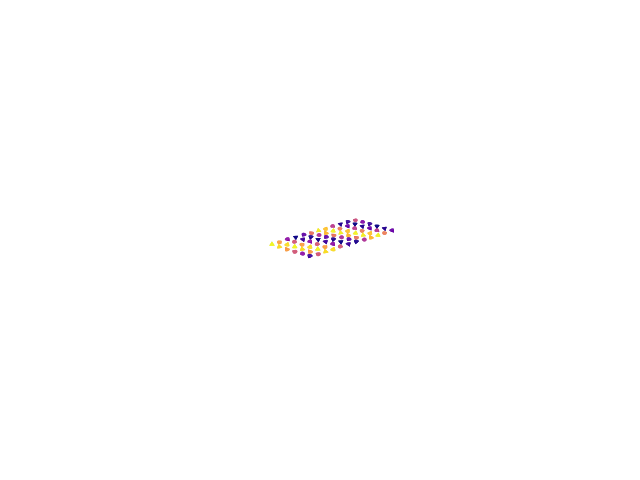

In [91]:
n1 = 6
n2 = 12
A_nn, coordinates = open_2dtriangular_lattice2(n1, n2)


"""
fig, ax = plt.subplots(1)
plot_lattice(ax, A_nn, coordinates, linewidth=2.0)
ax.set_axis_off()
fig.tight_layout()"""
#plt.savefig('/Users/louisprimeau/Downloads/lattice2.pdf')

l1, l2 = (1, 0), (np.cos(pi/6), np.sin(pi/6))
x, y = coordinates
x, y = x , y# + 3 * l2[1]
k = 1
k1 = (k, 0)
k2 = (k * np.cos(2*pi/3), k * np.sin(2*pi/3))
k3 = (k * np.cos(4*pi/3), k * np.sin(4*pi/3))
orientation = 0 #0.6 #5 * pi / 6
c, s = np.cos(orientation), np.sin(orientation)
k1 = (c * k1[0] + s * k1[1], -s * k1[0] + c * k1[1])
k2 = (c * k2[0] + s * k2[1], -s * k2[0] + c * k2[1])
k3 = (c * k3[0] + s * k3[1], -s * k3[0] + c * k3[1])

theta1 = pi/2
theta2 = 0 # pi/2
theta3 = 0

#B = Q_wave(x, y, *k1, theta1) - Q_wave(x, y, *k2, theta2) + Q_wave(x, y, *k3, theta3)
B = Q_waves2(x, y, *k1, -2 * pi / 3, theta1) #+ Q_waves2(x, y, *k2, 0, theta2) + Q_waves2(x, y, *k3, 2 * pi / 3, theta3)
B = B / np.linalg.norm(B, axis=0)

fig = plt.figure(); ax = plt.axes(projection='3d')
cone_plot(ax, x, y, np.arccos(B[2]), np.arctan2(B[1], B[0]), spatial_scale=3)
set_axes_equal(ax)
ax.set_axis_off()
ax.view_init(elev=10., azim=30)

#plt.savefig('/Users/louisprimeau/Downloads/spins2.pdf', transparent=True)



D = 0.5
mu = 1.55
J = 1.55

params = {'n1': n1,
          'n2': n2,
          'D': D,
          'mu': mu,
          'B': B.reshape(3, -1),
          'J': J,
          'adjacency': A_nn,
          'wave': -1}

H = make_H(params)

"""
fig, ax = plt.subplots(1, 2)
ax[0].matshow(H.real)
ax[1].matshow(H.imag)

ax[0].vlines((n1*n2, n1*n2*2, n1*n2*3), 0, 2*n1*n2*2-1, colors='k', linewidth=0.3)
ax[0].hlines((n1*n2, n1*n2*2, n1*n2*3), 0, 2*n1*n2*2-1, colors='k', linewidth=0.3)

fig.tight_layout()

"""

In [92]:
plt.savefig('/Users/louisprimeau/Research/skyrmions/figures/texture.pdf',bbox_inches='tight')

In [60]:
np.all(H == H.T.conj())

True

In [61]:
eigs, eigv = np.linalg.eigh(H)

indices = np.argsort(eigs)
eigs = eigs[indices]
eigv = eigv[:, indices]

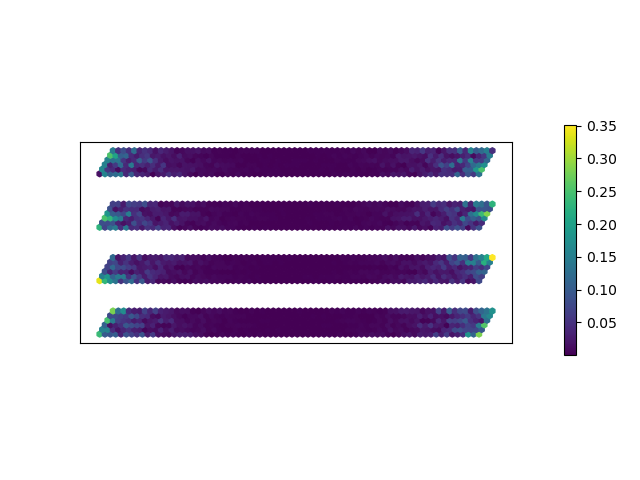

In [87]:
fig, axs = plt.subplots(1)
vmin = np.inf
vmax = -np.inf

ss = []
xys = []
for i in range(0,4, 1):
    idx = eigv.shape[1]//2 + i

    aa_u = np.abs(eigv[:n1*n2, idx]).reshape(n1, n2)
    aa_d = np.abs(eigv[n1*n2:2*n1*n2, idx]).reshape(n1, n2)
    ac_u = np.abs(eigv[2*n1*n2:3*n1*n2, idx]).reshape(n1, n2)
    ac_d = np.abs(eigv[3*n1*n2:4*n1*n2, idx]).reshape(n1, n2)
    s = np.sqrt(aa_u**2 + aa_d**2 + ac_u**2 + ac_d**2)
    
    vmin = min(vmin, np.min(s))
    vmax = max(vmax, np.max(s))
    
    x = coordinates[0]
    y = coordinates[1] + i * (n1 + 4)
    
    ss.append(s)
    xys.append((x,y))

    #vmin = min(np.min(aa_u), np.min(aa_d), np.min(ac_u), np.min(ac_d))
    #vmax = max(np.max(aa_u), np.max(aa_d), np.max(ac_u), np.max(ac_d))

    #fig, ax = plt.subplots(1,2)
    #show_wavefunction(ax[0], coordinates, aa_u, vmin=vmin, vmax=vmax)
    #show_wavefunction(ax[1], coordinates, aa_d, vmin=vmin, vmax=vmax)
    #ax[0].set_title('a↑'); ax[0].set_aspect(1.0)
    #ax[1].set_title('a↓'); ax[1].set_aspect(1.0)

    #fig, ax = plt.subplots(1,2)
    #show_wavefunction(ax[0], coordinates, ac_u, vmin=vmin, vmax=vmax)
    #show_wavefunction(ax[1], coordinates, ac_d, vmin=vmin, vmax=vmax)
    #ax[0].set_title('a†↑'); ax[0].set_aspect(1.0)
    #ax[1].set_title('a†↓'); ax[1].set_aspect(1.0)

    
for (x,y), s in zip(xys, ss):
    show_wavefunction(axs, (x, y), s, vmin=vmin, vmax=vmax, colorbar=False)
    
axs.set_aspect(1.0)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cNorm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
plt.colorbar(cm.ScalarMappable(norm=cNorm, cmap=cmap), ax=cbar_ax, fraction=0.36, pad=-1)
cbar_ax.set_axis_off()

plt.savefig('/Users/louisprimeau/Research/skyrmions/figures/zero_modes.pdf',bbox_inches='tight')

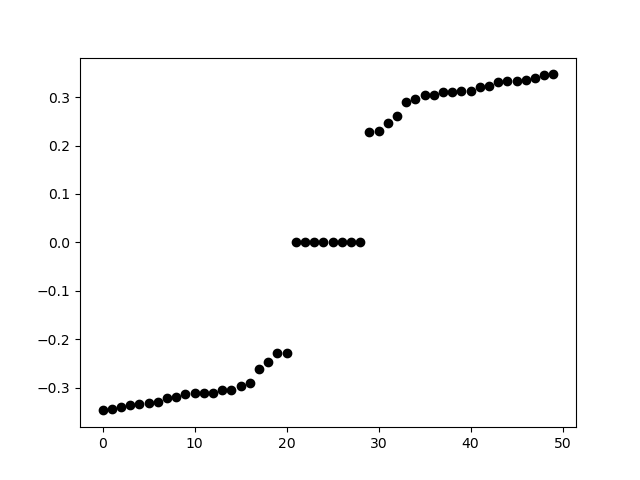

In [77]:
n = 50 #num eigs to plot
fig, ax = plt.subplots(1)
ax.scatter(np.arange(n), np.sort(eigs.real)[eigs.size//2 - n//2: eigs.size//2 + n//2], color='k', marker='o')
plt.savefig('/Users/louisprimeau/Research/skyrmions/figures/spectrum.pdf',bbox_inches='tight')